In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sklearn.model_selection import KFold
from keras import regularizers

In [13]:
# Load data
Xtrain2_b = np.load('Xtrain2_b.npy')
Ytrain2_b = np.load('Ytrain2_b.npy')
Xtest2_b = np.load('Xtest2_b.npy')
# Check dimensions
print(Xtrain2_b.shape)
print(Ytrain2_b.shape)
print(Xtest2_b.shape)

(547, 2304)
(547, 2304)
(196, 2304)


Preprocessing

In [14]:
print("Original unique values:", np.unique(Ytrain2_b))
Ytrain2_b = np.where(Ytrain2_b == 255, 1, Ytrain2_b)
print("Original unique values:", np.unique(Ytrain2_b))

Original unique values: [  0. 255.]
Original unique values: [0. 1.]


In [21]:
# Reshape data
Xtrain2_b = Xtrain2_b.reshape(547,48,48)
Ytrain2_b = Ytrain2_b.reshape(547,48,48)

# Scale data
train_images2_b = (Xtrain2_b).astype('float32')/255.0

Data split

In [22]:
# Split into training and validation set
X_train, X_val, y_train, y_val = train_test_split(train_images2_b, Ytrain2_b, test_size=0.2)

In [23]:
import numpy as np
import cv2  # If you want to use OpenCV for rotation

def augment_images_and_labels(images, labels):
    # Ensure images and labels have the same shape
    assert images.shape == labels.shape
    
    n_samples = images.shape[0]
    augmented_images = np.empty_like(images)
    augmented_labels = np.empty_like(labels)

    for i in range(n_samples):
        # Randomly choose to flip or rotate
        if np.random.rand() > 0.5:  # 50% chance to flip
            if np.random.rand() > 0.5:  # 50% chance to flip horizontally
                augmented_images[i] = np.flip(images[i], axis=1)  # Flip horizontally
                augmented_labels[i] = np.flip(labels[i], axis=1)  # Flip labels similarly
            else:  # Flip vertically
                augmented_images[i] = np.flip(images[i], axis=0)  # Flip vertically
                augmented_labels[i] = np.flip(labels[i], axis=0)  # Flip labels similarly
        else:  # Rotate
            angle = np.random.choice([90, 180, 270])  # Choose a random rotation angle
            # Rotate both images and labels
            augmented_images[i] = cv2.rotate(images[i].squeeze(), cv2.ROTATE_90_CLOCKWISE if angle == 90 else 
                                              cv2.ROTATE_180 if angle == 180 else 
                                              cv2.ROTATE_90_COUNTERCLOCKWISE)
            augmented_labels[i] = cv2.rotate(labels[i].squeeze(), cv2.ROTATE_90_CLOCKWISE if angle == 90 else 
                                               cv2.ROTATE_180 if angle == 180 else 
                                               cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return augmented_images, augmented_labels

# Example usage:
# images, labels = ...  # Load your images and labels
# augmented_images, augmented_labels = augment_images_and_labels(images, labels)


In [28]:
X_aug, y_aug = augment_images_and_labels(X_train,y_train)

In [29]:
X_train = np.concatenate((X_train,X_aug))
y_train = np.concatenate((y_train,y_aug))

In [30]:
y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]

Metric function

In [31]:
def balanced_accuracy(y_true, y_pred):
    # Convert logits to class predictions (0 or 1)
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))  # Round the predictions to get binary values
    
    # Compute confusion matrix components
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))  # True Positives
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))  # True Negatives
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))  # False Positives
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))  # False Negatives

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn + tf.keras.backend.epsilon())  # Avoid division by zero
    specificity = tn / (tn + fp + tf.keras.backend.epsilon())  # Avoid division by zero

    # Balanced Accuracy
    return (sensitivity + specificity) / 2  # Average of sensitivity and specificity

Set up model

In [40]:
def smaller_unet(input_shape):
    inputs = layers.Input(input_shape)
    
    # Encoder path (downsampling)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    drop1 = layers.Dropout(0.5)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(drop1)  # Output size: 24x24
    
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    drop2 = layers.Dropout(0.5)(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(drop2)  # Output size: 12x12
    
    # Bottleneck
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    drop3 = layers.Dropout(0.5)(conv3)
    
    # Decoder path (upsampling)
    up4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop3)
    merge4 = layers.concatenate([conv2, up4], axis=3)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    
    up5 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(drop4)
    merge5 = layers.concatenate([conv1, up5], axis=3)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(drop5)
    
    model = Model(inputs, outputs)
    
    return model

input_shape = (48, 48, 1)
model = smaller_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', balanced_accuracy])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 48, 48,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 48, 48,    │      9,248 │ conv2d_33[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 48, 48,    │          0 │ conv2d_34[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 24, 24,    │          0 │ dropout_15[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 24, 24,    │     36,928 │ conv2d_35[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 24, 24,    │          0 │ conv2d_36[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 12, 12,    │          0 │ dropout_16[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 12, 12,    │    147,584 │ conv2d_37[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 12, 12,    │          0 │ conv2d_38[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 24, 24,    │     32,832 │ dropout_17[0][0]  │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 24, 24,    │          0 │ conv2d_36[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 24, 24,    │     73,792 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 24, 24,    │     36,928 │ conv2d_39[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24, 24,    │          0 │ conv2d_40[0][0] 

 Total params: 483,393 (1.84 MB)

 Trainable params: 483,393 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Train model

In [41]:
reduce_lr = ReduceLROnPlateau(monitor='val_balanced_accuracy', factor=0.5, patience=5, min_lr=1e-9)

early_stopping = EarlyStopping(monitor='val_balanced_accuracy', patience=20, restore_best_weights=True, mode='max')

#callbacks=[reduce_lr, metrics, early_stopping]

history = model.fit(X_train, y_train, batch_size=64,
                         epochs=100,
                         validation_data=(X_val, y_val),
                         callbacks=[reduce_lr, early_stopping],
                         verbose=1)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.6789 - balanced_accuracy: 0.5009 - loss: 0.6653 - val_accuracy: 0.6996 - val_balanced_accuracy: 0.5000 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.7123 - balanced_accuracy: 0.5000 - loss: 0.6225 - val_accuracy: 0.6996 - val_balanced_accuracy: 0.5000 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - accuracy: 0.7134 - balanced_accuracy: 0.5000 - loss: 0.6109 - val_accuracy: 0.6996 - val_balanced_accuracy: 0.5000 - val_loss: 0.6064 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.7204 - balanced_accuracy: 0.5000 - loss: 0.5855 - val_accuracy: 0.6996 - val_balanced_accuracy: 0.5000 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 341ms/step - accuracy: 0.7086 - balanced_accuracy: 0.5009 - loss: 0.5801 - val_accuracy: 0.6996 - val_bala

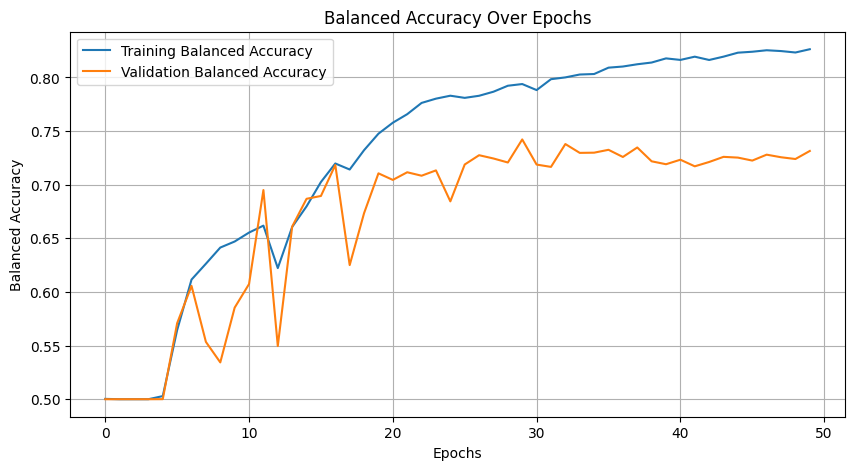

In [42]:
import matplotlib.pyplot as plt

# Extract metrics from history
val_balanced_accuracy = history.history.get('val_balanced_accuracy', [])
train_balanced_accuracy = history.history.get('balanced_accuracy', [])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_balanced_accuracy, label='Training Balanced Accuracy')
plt.plot(val_balanced_accuracy, label='Validation Balanced Accuracy')
plt.title('Balanced Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Balanced Accuracy')
plt.legend()
plt.grid()
plt.show()
